In [1]:
import kagglehub
import numpy as np
import struct
from array import array
from os.path  import join
from tqdm import tqdm

%matplotlib inline
import random
import matplotlib.pyplot as plt

from layers import Linear, ReLu, Softmax, MSELoss
from utils import DataLoader

# Качаю датасет и считываю его

In [2]:
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/alex/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [3]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)    

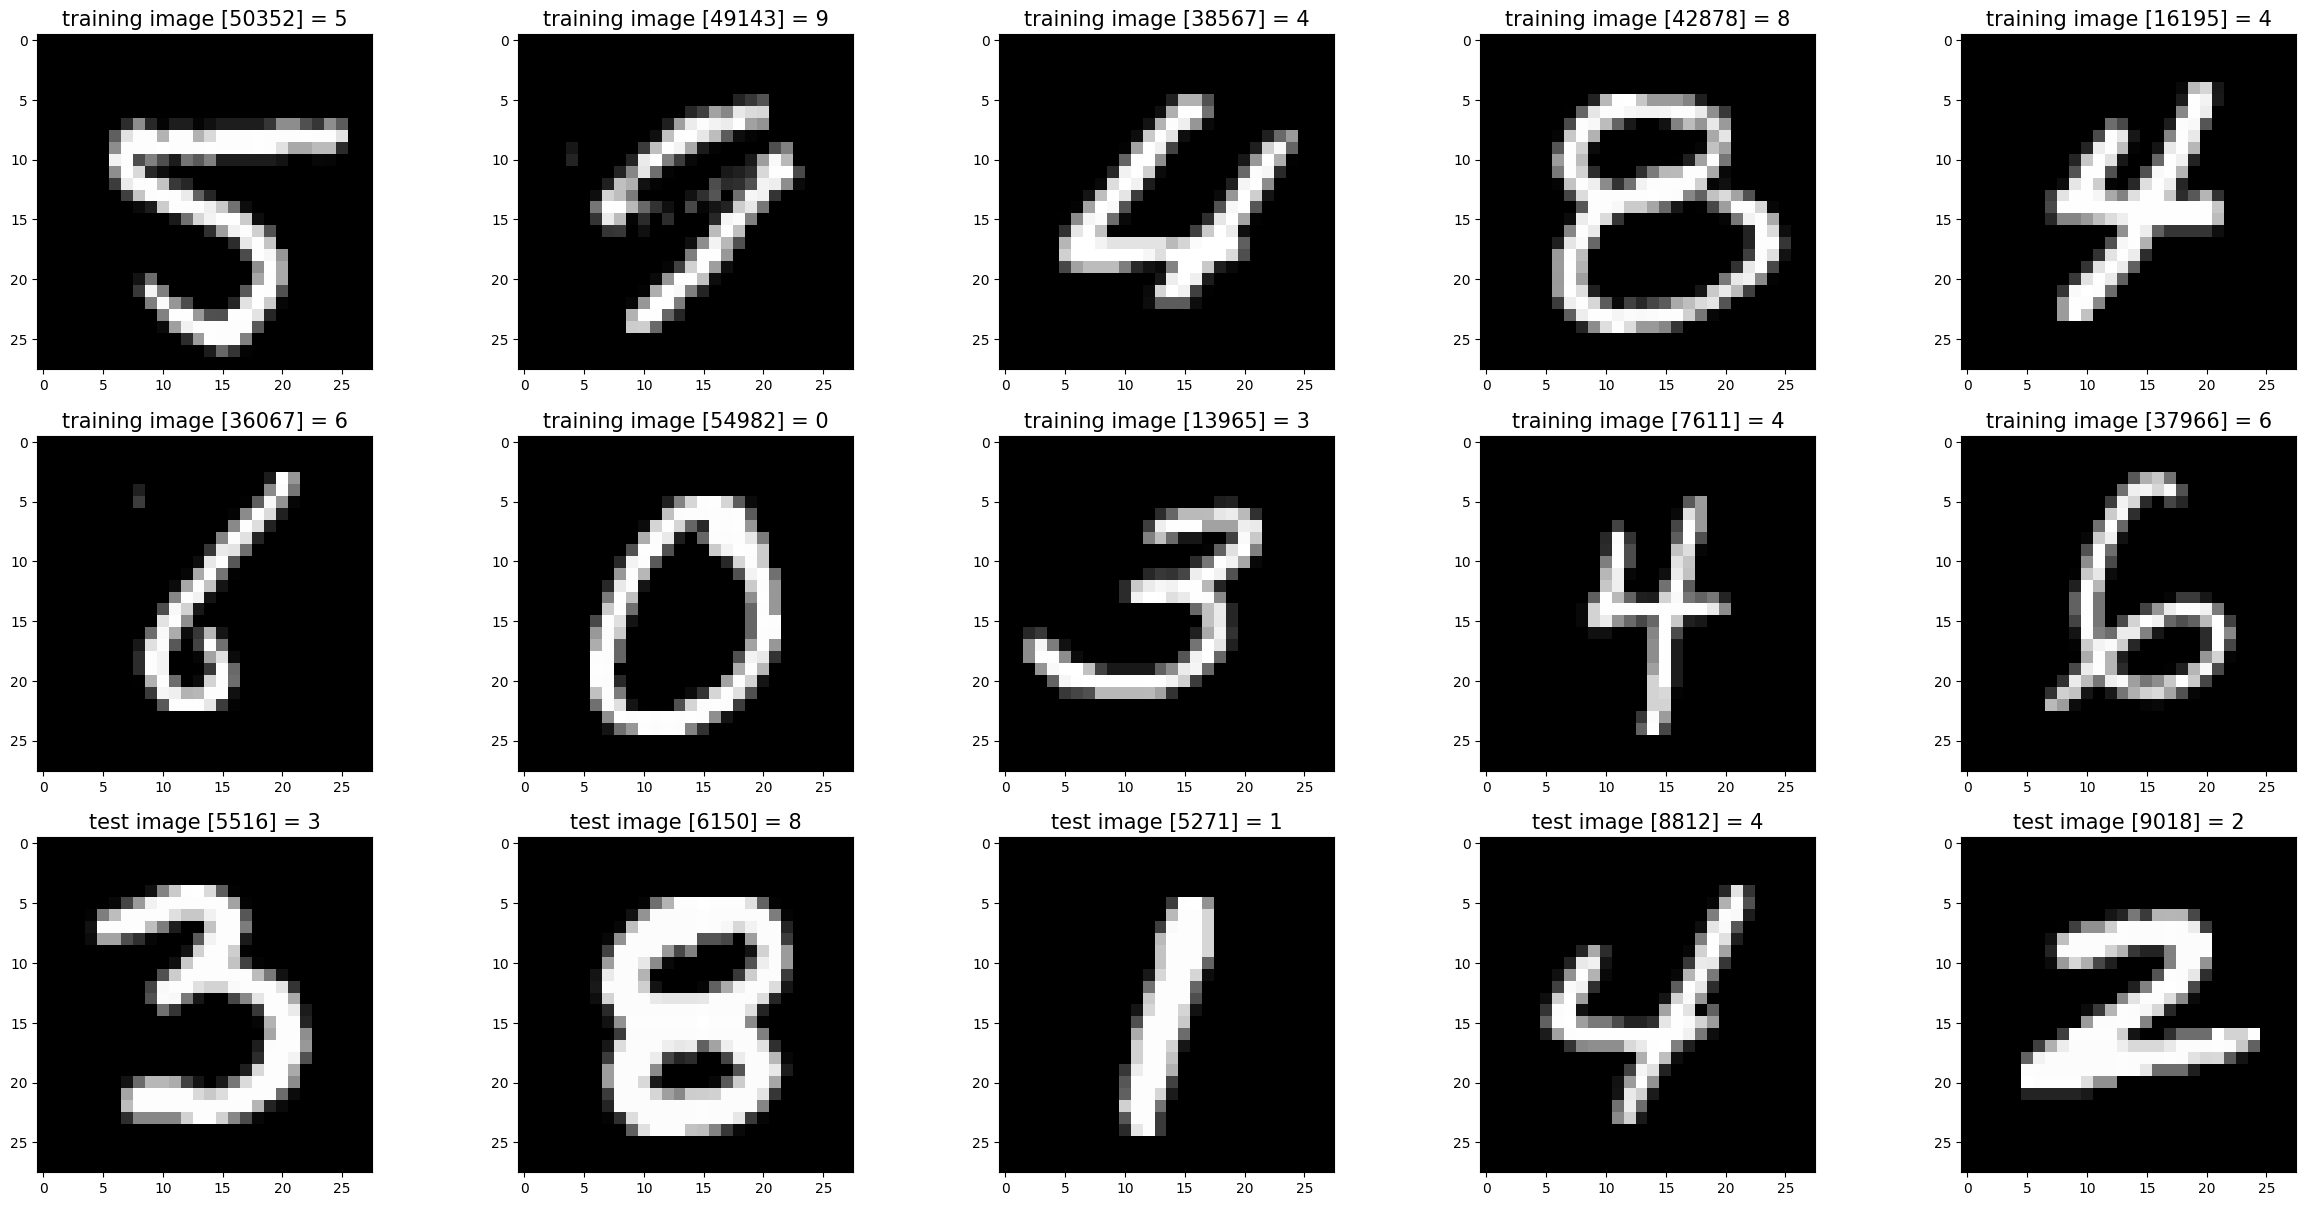

In [4]:
input_path = '/home/alex/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

Конвертирование датасета в numpy массивы и one-hot кодирование y_train и y_test

In [5]:
X_train = np.array(x_train)
X_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Нормализация пикселей

In [6]:
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Реализация моей сети с использованием слоев, реализованных в  файле layers.py

In [7]:
class AbobaNet:
    def __init__(self, in_dim, hidden_dim, out_dim):
        self.layers = [
            Linear(in_dim, hidden_dim),
            ReLu(),
            Linear(hidden_dim, out_dim),
            ReLu(),
            Softmax()
        ]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, out_grad, lr):
        for layer in self.layers[::-1]:
            if layer.name == 'Linear':
                out_grad = layer.backward(out_grad, lr)
            else:
                out_grad = layer.backward(out_grad)

# Тренировка моей сети

In [8]:
model = AbobaNet(784, 128, 10)

In [9]:
batch_size = 64
num_epochs = 15
learning_rate = 0.01

train_loader = DataLoader(X_train, y_train, batch_size=batch_size, shuffle=True)

loss_fn = MSELoss()

In [10]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):

        outputs = model.forward(X_batch)

        loss = loss_fn.forward(outputs, y_batch)

        grad_output = loss_fn.backward()
        model.backward(grad_output, learning_rate)

        if batch_idx % 400 == 0:
            print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss:.4f}")

Epoch 1/15
  Batch 1/938, Loss: 0.0900
  Batch 401/938, Loss: 0.0898
  Batch 801/938, Loss: 0.0897
Epoch 2/15
  Batch 1/938, Loss: 0.0895
  Batch 401/938, Loss: 0.0890
  Batch 801/938, Loss: 0.0881
Epoch 3/15
  Batch 1/938, Loss: 0.0873
  Batch 401/938, Loss: 0.0857
  Batch 801/938, Loss: 0.0827
Epoch 4/15
  Batch 1/938, Loss: 0.0797
  Batch 401/938, Loss: 0.0778
  Batch 801/938, Loss: 0.0646
Epoch 5/15
  Batch 1/938, Loss: 0.0691
  Batch 401/938, Loss: 0.0674
  Batch 801/938, Loss: 0.0526
Epoch 6/15
  Batch 1/938, Loss: 0.0531
  Batch 401/938, Loss: 0.0556
  Batch 801/938, Loss: 0.0453
Epoch 7/15
  Batch 1/938, Loss: 0.0518
  Batch 401/938, Loss: 0.0466
  Batch 801/938, Loss: 0.0501
Epoch 8/15
  Batch 1/938, Loss: 0.0430
  Batch 401/938, Loss: 0.0415
  Batch 801/938, Loss: 0.0363
Epoch 9/15
  Batch 1/938, Loss: 0.0415
  Batch 401/938, Loss: 0.0405
  Batch 801/938, Loss: 0.0383
Epoch 10/15
  Batch 1/938, Loss: 0.0403
  Batch 401/938, Loss: 0.0321
  Batch 801/938, Loss: 0.0285
Epoch 11/

# Инференс сети на тестовой выборке

In [ ]:
#кастомный даталоудер, реализованный в файле utils.py
test_loader = DataLoader(X_test, y_test, batch_size=1, shuffle=False)

In [12]:
correct = 0
total = 0

for X_batch, y_batch in tqdm(test_loader):
    
    outputs = model.forward(X_batch)

    predictions = np.argmax(outputs, axis=1)

    targets = np.argmax(y_batch, axis=1)

    correct += np.sum(predictions == targets)
    total += X_batch.shape[0]

    accuracy = (correct / total) * 100
    
print(f'Accuracy: {accuracy}')

100%|██████████| 10000/10000 [00:01<00:00, 7231.12it/s]

Accuracy: 88.94


Наглядная демонстрация предсказаний модели на тестовой выборке

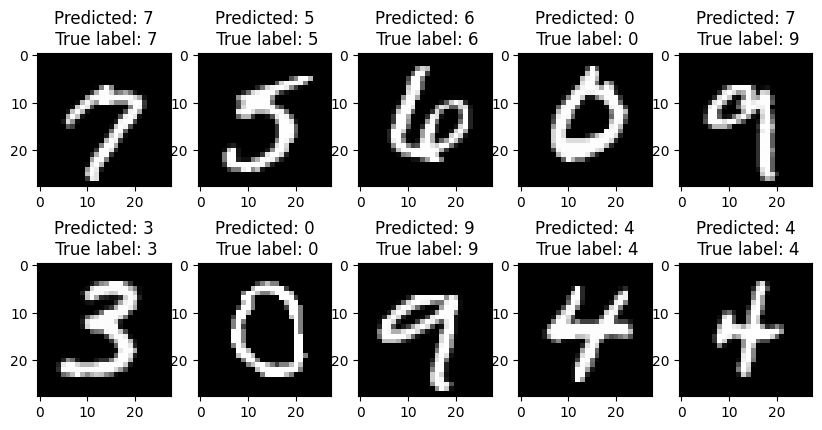

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(X_test) - 1)
    outputs = model.forward(X_test[idx])
    pred = np.argmax(outputs, axis=1)
    ax.imshow(x_test[idx], cmap=plt.cm.gray)
    ax.set_title(f'Predicted: {pred[0]}\n True label: {np.argmax(y_test[idx])}')

# Тесты слоев

In [15]:
import torch
import torch.nn.functional as F

In [16]:
batch_size = 2
in_dim = 8
out_dim = 4
num_classes = 10

### Тест слоя Linear

In [17]:
np.random.seed(54)
#generate weights and biases
W = np.random.randn(in_dim, out_dim).astype(np.float32)
biases = np.random.randn(1, out_dim).astype(np.float32)
#initialize my input and grad_out
my_input = np.random.randn(batch_size, in_dim).astype(np.float32)
out_grad = np.random.randn(batch_size, out_dim).astype(np.float32)
#initialize torch input and grad_out
torch_input = torch.tensor(my_input, requires_grad=True)
torch_out_grad = torch.tensor(out_grad)

#initialize my linear layer
my_layer = Linear(in_dim, out_dim)
my_layer.W = W
my_layer.bias = biases
#initialize torch linear layer
torch_layer = torch.nn.Linear(in_dim, out_dim, bias=True)
torch_layer.weight.data = torch.tensor(W.T)
torch_layer.bias.data = torch.tensor(biases)    

#my forward
my_output = my_layer.forward(my_input)

#torch forward
torch_output = torch_layer(torch_input)

assert np.allclose(my_output, torch_output.detach().numpy(), atol=1e-5), \
        "Forward outputs don't match"

# my backward
my_layer.backward(out_grad)

#torch backward
torch_output.backward(torch_out_grad)

assert np.allclose(my_layer.dW, torch_layer.weight.grad.numpy().T, atol=1e-5), \
        "Weights gradients don't match"

assert np.allclose(my_layer.db, torch_layer.bias.grad.numpy(), atol=1e-5), \
        "Bias gradients do not match"

assert np.allclose(my_layer.dX, torch_input.grad.numpy(), atol=1e-5), \
        "Input gradients do not match"

print("Linear layer test passed!")

Linear layer test passed!


### Тест ReLu

In [ ]:
np.random.seed(54)
#initialize my input and grad_out
my_input = np.random.randn(batch_size, in_dim).astype(np.float32)
out_grad = np.random.randn(batch_size, in_dim).astype(np.float32)
#initialize torch input
torch_input = torch.tensor(my_input, requires_grad=True)
torch_out_grad = torch.tensor(out_grad)

my_relu = ReLu()

torch_relu = torch.nn.ReLU()

torch_output = torch_relu(torch_input)
my_output = my_relu.forward(my_input)
assert np.allclose(my_output, torch_output.detach().numpy(), atol=1e-5), \
        "Forward outputs do not match"
        
torch_output.backward(torch_out_grad)
my_relu.backward(out_grad)
assert np.allclose(my_relu.dX, torch_input.grad.numpy(), atol=1e-5), \
        "Backward gradients do not match"
        
print("ReLU test passed!")


ReLU test passed!


### Тест MSELoss

In [ ]:
np.random.seed(54)
#generate preds and targets
predictions = np.random.randn(batch_size, num_classes).astype(np.float32)
targets = np.random.randn(batch_size, num_classes).astype(np.float32)

my_loss = MSELoss()

torch_loss = torch.nn.MSELoss()

predictions_torch = torch.tensor(predictions, requires_grad=True)
targets_torch = torch.tensor(targets)

#forward
torch_loss = torch_loss(predictions_torch, targets_torch)
my_loss_val = my_loss.forward(predictions, targets)
assert np.allclose(my_loss_val, torch_loss.item(), atol=1e-5), \
        "Loss values do not match"

#backward
torch_loss.backward()
grad = my_loss.backward()
assert np.allclose(grad, predictions_torch.grad.numpy(), atol=1e-5), \
        "Loss gradients do not match"

print("MSELoss test passed!")

MSELoss test passed!


### Тест Softmax

Функция backward_ у моего Softmax была написана специально для теста, но не использовалась при обучении, так как тогда градиент очень плохо распространялся и модель училась очень медленно. Поэтому при обучении используется метод backward (без нижнего подчеркивания в конце), который возвращает градиент, полученный на вход, никак не изменяя его.

In [ ]:
np.random.seed(54)

x = np.random.randn(batch_size, num_classes).astype(np.float32)
x_torch = torch.tensor(x, requires_grad=True)

# generate gradients
dL = np.random.randn(batch_size, num_classes).astype(np.float32)

# my forward
my_softmax = Softmax()
my_output = my_softmax.forward(x)
# pytorch forward
softmax_torch = F.softmax(x_torch, dim=1)
output_torch = softmax_torch.detach().numpy()
assert np.allclose(my_output, output_torch, atol=1e-6), \
    "Forward outputs do not match"

# my backward
my_grad = my_softmax.backward_(dL)
# pytorch backward
softmax_torch.backward(torch.tensor(dL))
grad_torch = x_torch.grad.numpy()
assert np.allclose(my_grad, grad_torch, atol=1e-6), "Backward gradients do not match"

print("All Softmax tests passed!")

All Softmax tests passed!
